In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder ,StandardScaler , MinMaxScaler ,RobustScaler
from sklearn.ensemble import RandomForestRegressor

In [2]:
divar_df = pd.read_pickle('../DataSets/clean_divar_data.pkl')

In [42]:
df = divar_df.copy()

In [43]:
df.drop(
    columns=[
        "location_latitude",
        "location_longitude",
        "location_radius",
        "building_age",
        "shamsi_date",
        "has_balcony",
        "has_elevator",
        "has_warehouse",
        "has_parking",
        "has_water",
        "has_electricity",
        "has_gas",
        "has_barbecue",
        "has_pool",
        "has_jacuzzi",
        "has_sauna",
        "has_security_guard",
        "extra_person_capacity",
        "cost_per_extra_person",
        "rent_price_on_regular_days",
        "rent_price_on_special_days",
        "rent_price_at_weekends",
    ],
    inplace=True,
)

In [44]:
object_columns = df.select_dtypes(include='object').columns.tolist()

In [45]:
label_encoders = {}  
for col in object_columns:
    le = LabelEncoder()
    # Handle missing values by treating them as a separate category
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    print(f"Encoded {col} with {len(le.classes_)} categories")


Encoded cat2_slug with 6 categories
Encoded cat3_slug with 16 categories
Encoded city_slug with 420 categories
Encoded neighborhood_slug with 1186 categories
Encoded user_type with 2 categories
Encoded rent_mode with 3 categories
Encoded rent_type with 2 categories
Encoded price_mode with 3 categories
Encoded credit_mode with 3 categories
Encoded deed_type with 5 categories
Encoded has_warm_water_provider with 4 categories
Encoded has_heating_system with 8 categories
Encoded has_cooling_system with 6 categories
Encoded has_restroom with 4 categories
Encoded building_direction with 5 categories
Encoded floor_material with 8 categories
Encoded property_type with 5 categories


In [39]:
# Scale numerical features
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
scaler = RobustScaler()

df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [47]:
target_columns = ["price_value", "rent_value", "credit_value", "transformable_price"]
price_columns = [
    "price_value",
    "rent_value",
    "credit_value",
    "transformable_price",
    "transformable_credit",
    "transformed_credit",
    "transformable_rent",
    "transformed_rent",
    "cost_per_extra_person",
    "rent_price_on_regular_days",
    "rent_price_on_special_days",
    "rent_price_at_weekends",
]


In [ ]:
price_related_cols = [col for col in numerical_features if 'price' in col.lower() or 'transformable' in col.lower()]


['price_mode',
 'price_value',
 'transformable_price',
 'transformable_credit',
 'transformable_rent',
 'price_per_sqm']


=== Correlation Analysis ===
Top 15 features by correlation with price:
   1. price_per_sqm: 0.8061
   2. rent_credit_transform: 0.5592
   3. credit_mode: 0.4046
   4. rent_mode: 0.3759
   5. cat2_slug: 0.1681
   6. cat3_slug: 0.1639
   7. is_rebuilt: 0.0806
   8. city_slug: 0.0782
   9. has_heating_system: 0.0748
  10. building_direction: 0.0743
  11. floor: 0.0707
  12. bulding_age_score: 0.0677
  13. user_type: 0.0555
  14. amenity_score: 0.0515
  15. building_size: 0.0501


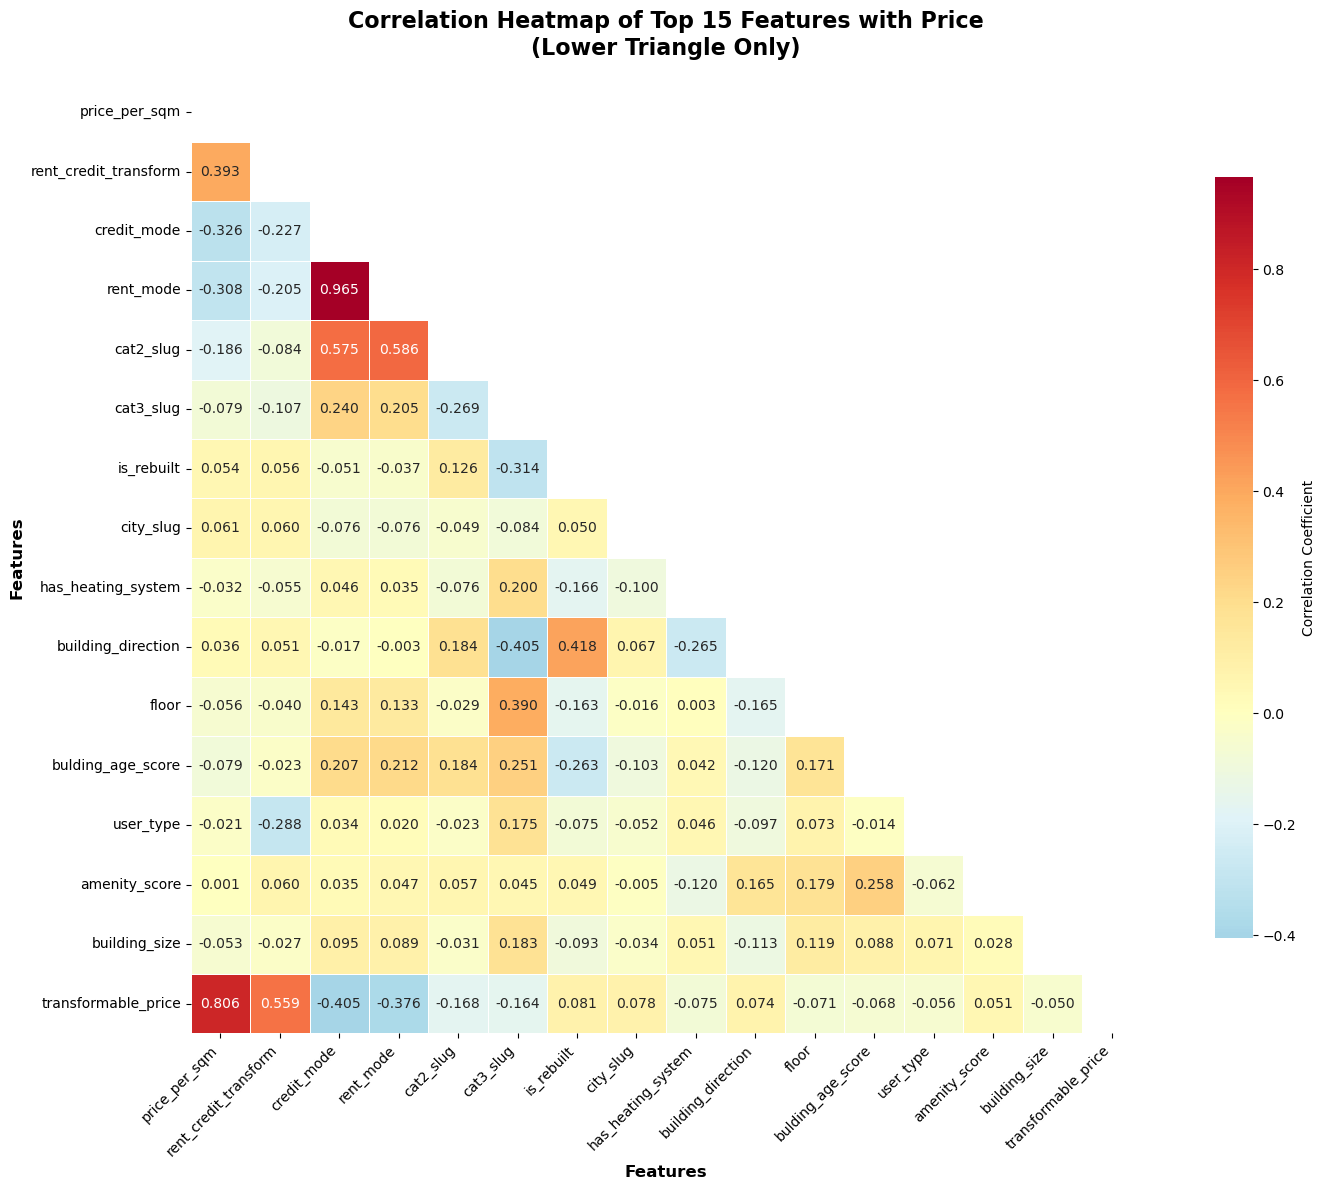

In [48]:

print("\n=== Correlation Analysis ===")

price_related_cols = [col for col in numerical_features if 'price' in col.lower() or 'transformable' in col.lower()]

# Get top features based on correlation with target variable
target_variable = 'transformable_price'
if target_variable in df.columns:
    
    # Calculate correlations with target variable
    correlations = df[numerical_features].corrwith(df[target_variable]).abs().sort_values(ascending=False)
    
    # Remove the target variable itself and get top features
    correlations = correlations.drop(price_columns, errors='ignore')
    top_features = correlations.head(15).index.tolist()
    
    print("Top 15 features by correlation with price:")
    for i, (feature, corr) in enumerate(correlations.head(15).items(), 1):
        print(f"  {i:2d}. {feature}: {corr:.4f}")
    
    # Create correlation matrix for top features + target
    correlation_features = top_features + [target_variable]
    correlation_matrix = df[correlation_features].corr()
    
    # Create the heatmap
    plt.figure(figsize=(16, 12))
    
    # Create mask for upper triangle to show only lower triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Generate heatmap
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                fmt='.3f', 
                cmap='RdYlBu_r', 
                center=0, 
                square=True,
                linewidths=0.5,
                cbar_kws={"shrink": .8, "label": "Correlation Coefficient"},
                annot_kws={'size': 10})
    
    plt.title('Correlation Heatmap of Top 15 Features with Price\n(Lower Triangle Only)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Features', fontsize=12, fontweight='bold')
    plt.ylabel('Features', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    

In [ ]:

# Additional analysis: Feature importance using Random Forest
print("\n--- Feature Importance Analysis ---")

# Prepare data for feature importance
feature_columns = [col for col in numerical_features if col != target_variable]
X_importance = df[feature_columns].fillna(df[feature_columns].median())
y_importance = df[target_variable].fillna(df[target_variable].median())

# Train Random Forest for feature importance
rf_importance = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_importance.fit(X_importance, y_importance)

# Get feature importances
importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_importance.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Features by Random Forest Importance:")
for i, (_, row) in enumerate(importance_df.head(15).iterrows(), 1):
    print(f"  {i:2d}. {row['feature']}: {row['importance']:.4f}")

# Feature importance plot
plt.figure(figsize=(12, 8))
top_15_importance = importance_df.head(15)

bars = plt.barh(range(len(top_15_importance)), top_15_importance['importance'], 
                color='lightcoral', alpha=0.8)
plt.yticks(range(len(top_15_importance)), top_15_importance['feature'])
plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
plt.title('Top 15 Feature Importances (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
            f'{width:.3f}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:

# Save scaled data
df_scaled.to_pickle("../DataSets/scaled_divar_data.pkl")

# =============================================================================
# STEP : FEATURE IMPORTANCE AND CORRELATION ANALYSIS
# =============================================================================



=== Correlation Analysis ===
Top 15 features by correlation with price:
   1. price_per_sqm: 0.8061
   2. rent_credit_transform: 0.5592
   3. transformed_credit: 0.3049
   4. transformed_rent: 0.2715
   5. transformable_credit: 0.2704
   6. credit_value: 0.2703
   7. has_pool: 0.1868
   8. transformable_rent: 0.0991
   9. rent_value: 0.0978
  10. is_rebuilt: 0.0806
  11. floor: 0.0707
  12. bulding_age_score: 0.0677
  13. building_age: 0.0662
  14. construction_year: 0.0662
  15. has_elevator: 0.0586


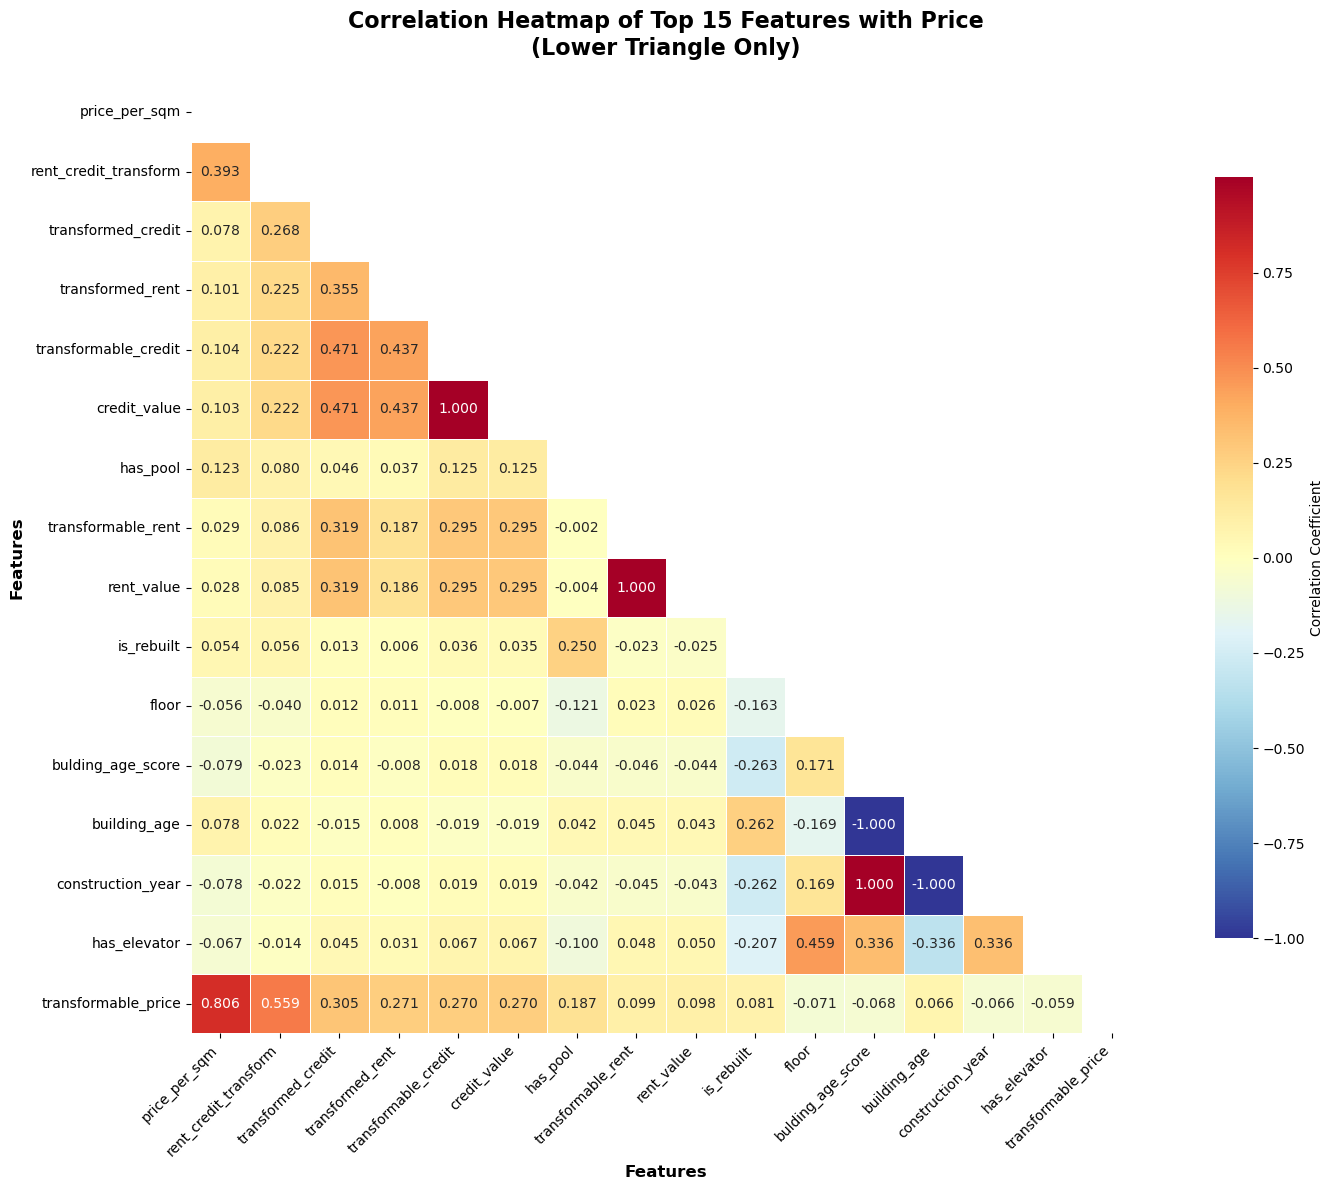


--- Feature Importance Analysis ---
Top 15 Features by Random Forest Importance:
   1. price_per_sqm: 0.9976
   2. transformed_rent: 0.0011
   3. transformed_credit: 0.0009
   4. building_size: 0.0004
   5. rent_credit_transform: 0.0000
   6. has_business_deed: 0.0000
   7. unit_per_floor: 0.0000
   8. regular_person_capacity: 0.0000
   9. has_balcony: 0.0000
  10. transformable_credit: 0.0000
  11. amenity_score: 0.0000
  12. location_latitude: 0.0000
  13. location_radius: 0.0000
  14. location_longitude: 0.0000
  15. price_value: 0.0000


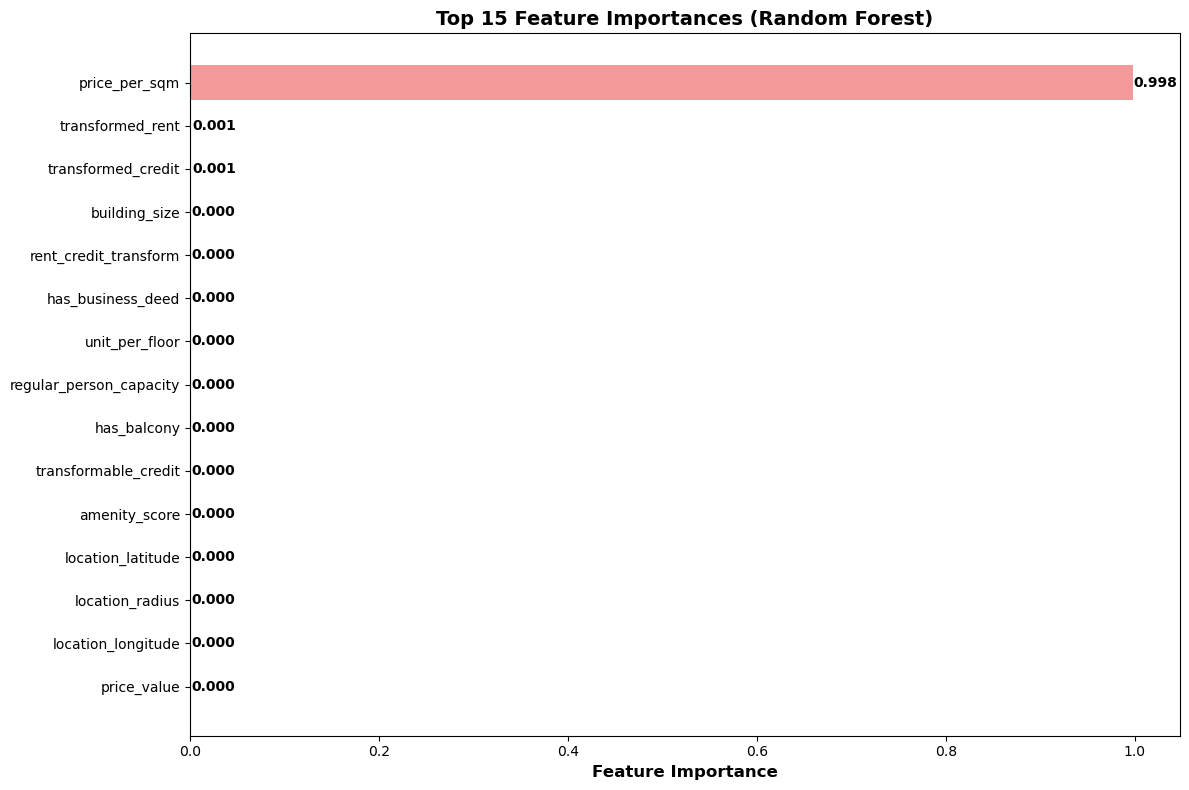

In [ ]:

print("\n=== Correlation Analysis ===")

# Select numerical columns for correlation analysis
numerical_cols = df_filterd.select_dtypes(include=[np.number]).columns.tolist()
price_related_cols = [col for col in numerical_cols if 'price' in col.lower() or 'transformable' in col.lower()]

# Get top features based on correlation with target variable
target_variable = 'transformable_price'
if target_variable in df_filterd.columns:
    
    # Calculate correlations with target variable
    correlations = df_filterd[numerical_cols].corrwith(df_filterd[target_variable]).abs().sort_values(ascending=False)
    
    # Remove the target variable itself and get top features
    correlations = correlations.drop(target_variable, errors='ignore')
    top_features = correlations.head(15).index.tolist()
    
    print("Top 15 features by correlation with price:")
    for i, (feature, corr) in enumerate(correlations.head(15).items(), 1):
        print(f"  {i:2d}. {feature}: {corr:.4f}")
    
    # Create correlation matrix for top features + target
    correlation_features = top_features + [target_variable]
    correlation_matrix = df_filterd[correlation_features].corr()
    
    # Create the heatmap
    plt.figure(figsize=(16, 12))
    
    # Create mask for upper triangle to show only lower triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Generate heatmap
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                fmt='.3f', 
                cmap='RdYlBu_r', 
                center=0, 
                square=True,
                linewidths=0.5,
                cbar_kws={"shrink": .8, "label": "Correlation Coefficient"},
                annot_kws={'size': 10})
    
    plt.title('Correlation Heatmap of Top 15 Features with Price\n(Lower Triangle Only)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Features', fontsize=12, fontweight='bold')
    plt.ylabel('Features', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Additional analysis: Feature importance using Random Forest
    print("\n--- Feature Importance Analysis ---")
    
    # Prepare data for feature importance
    feature_columns = [col for col in numerical_cols if col != target_variable]
    X_importance = df_filterd[feature_columns].fillna(df_filterd[feature_columns].median())
    y_importance = df_filterd[target_variable].fillna(df_filterd[target_variable].median())
    
    # Train Random Forest for feature importance
    rf_importance = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_importance.fit(X_importance, y_importance)
    
    # Get feature importances
    importance_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': rf_importance.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 15 Features by Random Forest Importance:")
    for i, (_, row) in enumerate(importance_df.head(15).iterrows(), 1):
        print(f"  {i:2d}. {row['feature']}: {row['importance']:.4f}")
    
    # Feature importance plot
    plt.figure(figsize=(12, 8))
    top_15_importance = importance_df.head(15)
    
    bars = plt.barh(range(len(top_15_importance)), top_15_importance['importance'], 
                   color='lightcoral', alpha=0.8)
    plt.yticks(range(len(top_15_importance)), top_15_importance['feature'])
    plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
    plt.title('Top 15 Feature Importances (Random Forest)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
